# Uncovering Hidden Fraud Schemes Through Transaction Network Analysis
## Introduction and problem statement

In the investigation of suspicious trading behavior—particularly when clients exhibit signs of **bonus-hunting and self-referral strategies**—standard methods of identifying collusion often prove insufficient. Techniques like detecting **reverse hedging**, **device CID matching**, or **IP address correlation** are useful, but not always conclusive.

A bonus hunter may deliberately use **separate accounts**, **distinct devices**, and **different IP addresses** to obscure their identity and evade detection. In such cases, no direct digital overlap exists, leaving compliance teams without solid grounds to impose restrictions or sanctions.

This is where **statistical and graph-based analysis of transaction networks** becomes a powerful tool. By examining how funds flow between client wallets—often across accounts that appear unrelated on the surface—analysts can identify **hidden relationships**, **coordinated behavior**, and **transaction patterns** indicative of fraudulent schemes.

Such approaches extend beyond conventional traceability and open the door to a deeper, data-driven understanding of client behavior in complex ecosystems.



## A Practical Case Study:  
### Detecting Hidden Links Between Clients Without Direct Technical Overlap

To illustrate the effectiveness of this approach, let’s consider a real-world case from my professional practice.

In this case, several clients demonstrated **suspiciously synchronized trading behavior**, closely aligned with known **bonus-hunting tactics**. However, conventional forensic checks—such as matching device CIDs or identifying shared IP addresses—revealed **no direct technical intersection** between the accounts.

Despite the absence of surface-level connections, transaction network analysis helped uncover **a hidden structure of interlinked wallet activity** that provided compelling evidence of coordination. Through graph-based modeling and statistical inference, it became possible to demonstrate that these clients were not acting independently, but rather as part of a broader, concealed strategy.

This case highlights how **network analysis can expose behavioral collusion** even when all direct identifiers have been intentionally obfuscated.


### Loading Transaction Data for Four Clients

> ⚠️ **Disclaimer:**  
> All client-related data used in this analysis has been **anonymized and altered** to ensure full compliance with confidentiality and data protection standards.  
> Any resemblance to real individuals or accounts is purely coincidental.

To begin the analysis, we load transactional data associated with four specific clients that demonstrated common suspicious trading activity.  
Each transaction record includes the following key columns:

- **Txn Hash** — unique transaction identifier (hash)
- **Block** — blockchain block number in which the transaction was recorded
- **Time(UTC)** — timestamp of the transaction in UTC
- **From** — sender wallet address
- **To** — recipient wallet address
- **Token** — full token identifier (contract or internal ID)
- **Token Symbol** — abbreviated token symbol (e.g., USDT, ETH)
- **Amount/TokenID** — amount transferred, or token ID in the case of NFTs
- **Result** — textual result or system feedback on the transaction
- **Status** — status flag (e.g., Success / Failed)
- **UID** — anonymized client identifier assigned within the system

This dataset includes **on-chain transfer data** across multiple tokens and wallets,  
allowing us to model the transactional network and search for patterns of interaction  
between accounts potentially controlled by the same entity.

We will now focus on transactions involving **four selected UIDs**, whose trading behavior has raised internal compliance concerns.

In [51]:
from pathlib import Path
import pandas as pd
import numpy as np
from numpy import random as nprand
import networkx as nx 
import networkx.algorithms.community as nxcom
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')
import community as community_louvain
import random
from sklearn.metrics.pairwise import cosine_similarity

# Путь к файлам
base_path = Path(r'C:\Users\a.stremousov\Downloads')

uids = ['314253', '481029', '119032', '693219']
dataframes = []

for uid in uids:
    file_path = base_path / f'{uid}.csv'
    df = pd.read_csv(file_path)
    df['UID'] = uid
    dataframes.append(df)

# Объединение всех DataFrame
uid_total = pd.concat(dataframes, ignore_index=True)

# Удаление строк, содержащих '-' в столбце 'Token Symbol'
UID_total = uid_total[~uid_total['Token Symbol'].str.contains('-', regex=False)]

In [50]:
UID_total

,Txn Hash,Block,Time(UTC),From,To,Token,Token Symbol,Amount/TokenID,Result,Status,UID
0,a2c56aaf5e93aef876d2a7ffd855696a1e95fe21ae97ed...,46034710,2024-04-02 10:40:24,wYFpo5qNPmq9Ra43f21RZTVvrouwKpo48Q,1HQeEZQ7pvQiTm3JGozFZogXNCzew5B2jE,TZpNS8i8gCjLjjeQ7zx6TtGtqHR4q8KLoY,USDT,58000.000000,SUCCESS,CONFIRMED,314253
1,af5a2630242e87dd751a3f06a80114222b0d7a44caf25d...,26574066,2024-04-02 07:51:18,rtzjoJvET3zTZGNDvvrtEDkDiA1iqATAXS,wF4r5Po9Q4mYvRK8VT13uo2wopqaqRpNZf,qRo876q4SGeitxYHzLN8LjKQpjgtTjZTC8,USDT,18535.435057,SUCCESS,CONFIRMED,314253
2,edaebc5078b33a1343b29fb9ddead6e25db1cb1d9c9377...,66480418,2024-04-01 16:09:12,AvJijEXDozN3SrZDTvittvGzAk1TATEqrD,9oq4qpQmZRF15orfPVKpNY8T2wv4Ru3oaw,K8Hje6qxtLLNY7TGjCg88R4zptTiqSQoZj,USDT,25000.000000,SUCCESS,CONFIRMED,314253
3,dacc9e2d51ce6d7669468abd5e0c00d55ba675a288841a...,90650363,2024-03-29 13:32:15,StaTmSELE2AvzeWM5rmszrwzDDDDqVD4eq,8o54KPVaRrQowpoF49mvYfNwTp2Zqq3u1R,i4LxpZgNjKHz8LCjo7eQYRSTt8G68jqtqT,USDT,0.003131,SUCCESS,CONFIRMED,314253
4,d0021fb88dec28f37e52b52d88678dc5d528db6e6f53be...,82705369,2024-03-29 13:30:51,bveR1F8y6RYU6gSMTZGq1UQ4goZfeAviMS,fPqrwqo52o4wRomNR39FvVu41Kp8pQaYTZ,TqezqRHj47GiQLCjpNoLx88KYgT8S6jtZt,USDT,14000.000000,SUCCESS,CONFIRMED,314253
...,...,...,...,...,...,...,...,...,...,...,...
2129,4ac5856774f20a1e569c33d0e92ed6ff5d38f69005ab50...,66030733,2024-03-18 06:02:48,C4KXDSJcVTs7s2kK4BoWgUwTLk8dqGHQTy,mfT4fH9KTT6rXqSPN8RCAJ6LtTJ1Q8G6iU,7GQCj8LzR8jteqqYtZLg48xTTSNiHpo6jK,USDT,0.000000,SUCCESS,CONFIRMED,693219
2130,b66957f1d743549f0f3901bbaaa93af652cbb524a276a0...,06307631,2024-03-18 06:02:42,8CdwBHTXLTs4yKWosUJ4Qk7SVKDqkT2cGg,fnPXSfy317LMCuQH6hVymUy5Wm3zbF3a3T,8jZ47itYo8G8gSTCNptTjqLLRxQ6HzejqK,USDT,50000.000000,SUCCESS,CONFIRMED,693219
2131,4fdf5219bbf5c14ad522258b0fce2c765a46a0f491b33b...,76030623,2024-03-18 06:00:30,fj6VfmM6qmMX39qD1WyDf8Zk14s1LTPfyU,dTcXWKTJDV4LQy8kCoBqH2TUK7wkSssg4G,RG8C8TK6NoiLSgHLjqjtYZztTpq7jx84Qe,USDT,0.601600,SUCCESS,CONFIRMED,693219
2132,56ad5da804107b98601877932f65484c5adb27d0c13e66...,53360606,2024-03-18 05:57:21,LWKo2H8BqkKTVgwXcJdST4ysQTGkDs7U4C,5a1SyUHfyCWm6mTh3F3XMVLuPbzn7yf33Q,oqj4TjZxp8LtY8j7e8qS6zQCLNTiGtgHRK,USDT,16000.000000,SUCCESS,CONFIRMED,693219


### Representing Transactions as an Undirected Graph

In this analysis, we model the transaction data as an **undirected, unweighted graph**,  
where each node represents a unique wallet address, and each edge indicates **the existence of at least one transaction** between two wallets — regardless of direction, amount, or frequency.

Mathematically, the graph is defined as:

\\[
G = (V, E)
\\]

Where:

- \\( V \\) — the set of **nodes**, each corresponding to a wallet address  
- \\( E \subseteq \{ \{u, v\} \mid u, v \in V,\, u \neq v \} \\) — the set of **undirected edges**, where an edge \\( \{u, v\} \\) means that **at least one transaction** occurred between wallet \\( u \\) and wallet \\( v \\)

Unlike directed or weighted graphs, this structure captures only the **existence of a transactional relationship**, without considering:
- Who sent or received the funds
- The number of transactions
- The total amount transferred

This representation is especially useful for identifying **clusters of interaction**, **mutual associations**, or **hidden structural connections** that may indicate coordinated activity, even when technical overlaps (such as IP or device ID) are absent.


In [52]:
all_nodes = pd.concat([UID_total[['To','Amount/TokenID','UID']].groupby('To').sum(),UID_total[['From','Amount/TokenID','UID']].groupby('From').sum()],axis=0)
all_nodes = all_nodes.groupby(all_nodes.index).sum()
all_nodes['UID'] = all_nodes['UID'].apply(lambda x: str(x)[:8])

In [53]:
edges = UID_total[['From','To','UID']]

In [54]:
graph = nx.from_pandas_edgelist(edges,'From','To', edge_attr=True)

### 🔍 Exploratory Network Analysis: Visualizing Structure and Communities

To better understand the structure of interactions between wallets, we perform an **exploratory network analysis**.  
This involves:

- Building an **undirected, unweighted graph** where nodes are wallet addresses and edges represent the existence of at least one transaction between them
- Applying **community detection algorithms** to identify groups of closely connected nodes
- Visualizing the resulting graph and communities

---

### 📊 Community Detection with the Louvain Method

To detect communities, we use the **Louvain method**, a popular algorithm that optimizes a quality function called **modularity**.

---

### 🧮 Modularity Formula

Modularity is a scalar value between -1 and 1 that measures the density of links **inside communities** compared to links **between communities**.

Let:

- \\( G = (V, E) \\) be an undirected graph
- \\( A_{ij} \\) — the adjacency matrix (1 if an edge exists between \\( i \\) and \\( j \\), 0 otherwise)
- \\( k_i \\) — degree of node \\( i \\)
- \\( m = |E| \\) — total number of edges in the graph
- \\( c_i \\) — community assignment of node \\( i \\)
- \\( \delta(c_i, c_j) \\) — 1 if nodes \\( i \\) and \\( j \\) are in the same community, 0 otherwise

The modularity \\( Q \\) is defined as:

\\[
Q = \frac{1}{2m} \sum_{i, j} \left[ A_{ij} - \frac{k_i k_j}{2m} \right] \delta(c_i, c_j)
\\]

This formula compares the actual number of edges within a community to the expected number in a random graph with the same degree distribution.

---

### 🔄 Louvain Algorithm — Greedy Modularity Maximization

1. **Initialization:** Assign each node to its own community.
2. **Local Moving:** Iteratively move nodes to neighboring communities **if the modularity increases**.
   - For each node \\( i \\), consider moving it to the community of neighbor \\( j \\)
   - Compute the **modularity gain**:

\\[
\Delta Q = \left[ \frac{\Sigma_{\text{in}} + k_{i,\text{in}}}{2m} - \left( \frac{\Sigma_{\text{tot}} + k_i}{2m} \right)^2 \right]
-
\left[ \frac{\Sigma_{\text{in}}}{2m} - \left( \frac{\Sigma_{\text{tot}}}{2m} \right)^2 - \left( \frac{k_i}{2m} \right)^2 \right]
\\]

Where:
- \\( \Sigma_{\text{in}} \\): sum of weights of edges inside community
- \\( \Sigma_{\text{tot}} \\): total degree of the community
- \\( k_i \\): degree of node \\( i \\)
- \\( k_{i,\text{in}} \\): sum of weights from node \\( i \\) to the target community

3. **Aggregation:** After no further improvement, collapse each community into a single super-node and repeat the process on the new graph.

This multi-level approach continues until modularity no longer improves.


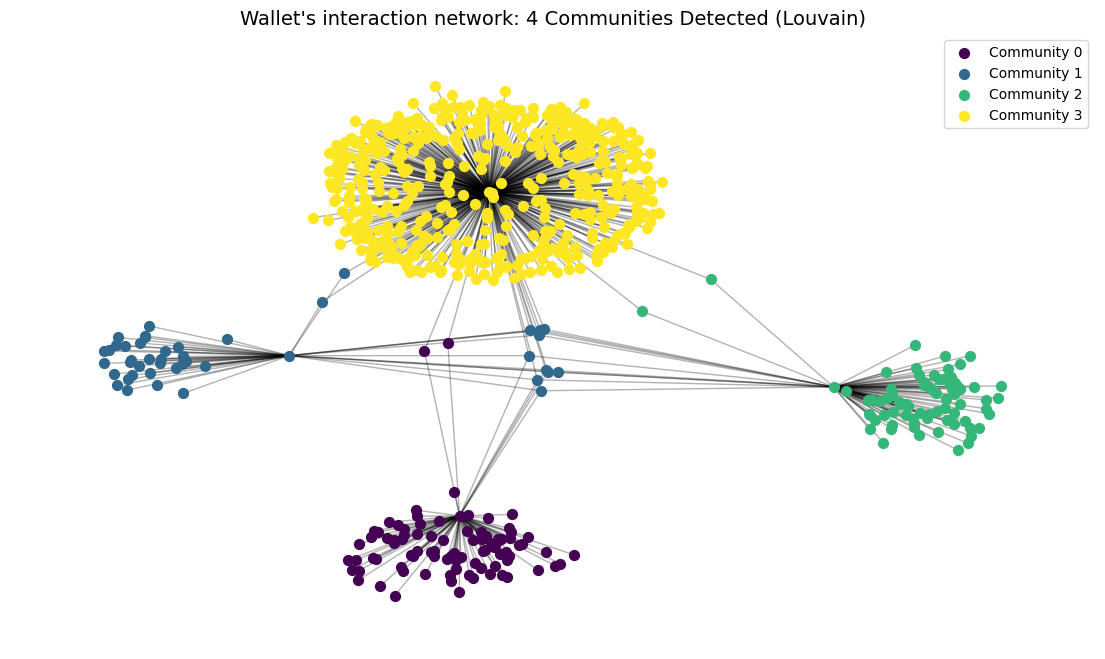

In [19]:
partition = community_louvain.best_partition(graph)
num_communities = len(set(partition.values()))
cmap = cm.get_cmap('viridis', num_communities)
pos = nx.spring_layout(graph, seed=42)

plt.figure(figsize=(14, 8))
for com in set(partition.values()):
    nodes_in_com = [node for node in partition if partition[node] == com]
    nx.draw_networkx_nodes(
        graph, pos,
        nodelist=nodes_in_com,
        node_size=50,
        node_color=[cmap(com)],
        label=f'Community {com}'
    )

nx.draw_networkx_edges(graph, pos, alpha=0.3)

# Оформление
plt.title(f"Wallet's interaction network: {num_communities} Communities Detected (Louvain)", fontsize=14)
plt.axis('off')
plt.legend(scatterpoints=1)
plt.show()

After visualizing the wallet interaction network using Louvain modularity, I initially identified four distinct communities based purely on the density of transactions between wallets. While this helped highlight clusters of frequent interaction, it quickly became clear that modularity-based methods were not sufficient for deeper investigation. 

In my work analyzing client activity in a brokerage environment — where **bonus hunting**, **self-referral schemes**, and **coordinated wallet usage** are common risks — I needed a more nuanced understanding of the relationships and roles of individual wallets within the network.

The Louvain method doesn't capture **structural equivalence** or **functional similarities** — for example, a wallet acting as a central hub across multiple groups, or multiple wallets exhibiting mirrored transactional behavior typical of affiliate farming or airdrop exploitation. To go beyond just *"who talks to whom"*, I shifted to using **Node2Vec** to generate vector embeddings for each wallet node.

Node2Vec allowed me to represent each node in a continuous vector space, preserving both **local neighborhood structure** and **global positional context** through biased random walks. This opened up a new layer of analysis — letting me compare wallets not just by direct connection, but by behavioral similarity and structural roles.

With these embeddings, I could:
- cluster wallets more meaningfully,
- detect anomalous patterns,
- and lay the groundwork for downstream classification tasks (e.g., predicting suspicious behavior or identifying high-risk clients).

It became an essential tool for dissecting **complex, coordinated strategies** that weren’t obvious in the raw graph structure.


### 🧠 Mathematical Foundations of Node2Vec

Node2Vec combines two core components:

1. A **stochastic model for biased random walk** strategy to sample node sequences from the graph,
2. A **Skip-Gram model** to learn embeddings from those sequences.

---

## 1. 📈 Biased Random Walks as a Stochastic Process

Given a graph \( G = (V, E) \), Node2Vec defines a second-order **Markov chain** to generate random walks.

Let:

- $v_i$ — the current node  
- $v_{i-1}$ — the previous node  
- $x$ — a candidate next node

The transition probability is defined as:

\\[
\mathbb{P}(v_{i+1} = x \mid v_i = v, v_{i-1} = t) = \frac{\pi_{vx}}{Z}
\\]

Where:

- $\pi_{vx} = \alpha_{pq}(t, x) \cdot w_{vx}$  
- $w_{vx}$ is the edge weight (usually 1)  
- $Z$ is a normalization constant  
- $\alpha_{pq}(t, x)$ is the **bias function**


\\[
\alpha_{pq}(t, x) =
\begin{cases}
\frac{1}{p}, & \text{if } d_{tx} = 0 \quad (\text{return step}) \\\\
1,           & \text{if } d_{tx} = 1 \quad (\text{stay close}) \\\\
\frac{1}{q}, & \text{if } d_{tx} = 2 \quad (\text{exploration})
\end{cases}
\\]

Here:

- \( p \) controls the likelihood of returning to the previous node,
- \( q \) controls outward exploration.

---

## 2. 📚 Skip-Gram Objective for Learning Embeddings

Once walks are generated, Node2Vec treats them like sentences and trains a Skip-Gram model.

Goal: Learn a function

\\[
f: V \rightarrow \mathbb{R}^d
\\]

such that for each node \( v \), nearby nodes \( u \) in the walk window are likely under:

\\[
\max_f \sum_{v \in V} \sum_{u \in \mathcal{N}_w(v)} \log \mathbb{P}(u \mid f(v))
\\]

With:

\\[
\mathbb{P}(u \mid f(v)) = \frac{\exp(f(u)^\top f(v))}{\sum_{u' \in V} \exp(f(u')^\top f(v))}
\\]

This softmax is expensive for large graphs, so Node2Vec uses **negative sampling**.

---

### 🔄 Negative Sampling Approximation

The softmax is replaced with the following objective:

\\[
\log \sigma(f(u)^\top f(v)) + \sum_{i=1}^k \mathbb{E}_{u_i \sim P_n(u)} \left[ \log \sigma(-f(u_i)^\top f(v)) \right]
\\]

Where:

- $\sigma(x) = \frac{1}{1 + e^{-x}}$ is the sigmoid function  
- $u$ is a positive (context) node  
- $u_i$ are negative samples from the noise distribution $P_n(u)$  
- $k$ is the number of negative samples

---

## 📦 Final Output

After training, each node $v \in V$ is represented by a dense embedding:

\\[
\mathbf{z}_v = f(v) \in \mathbb{R}^d
\\]

These vectors preserve both **local neighborhoods** and **global structural roles**,  
and can be used for clustering, anomaly detection, or link prediction.


In [2]:
import pandas as pd
import networkx as nx

# Загрузи свой DataFrame
df = UID_total.copy()

# Оставим только успешные переводы
df = df[(df['Status'] == 'CONFIRMED') & (df['Result'] == 'SUCCESS')]

# Построим направленный граф: узлы — кошельки, ребра — переводы
G = nx.from_pandas_edgelist(
    df,
    source='From',
    target='To',
    edge_attr='Amount/TokenID',
    create_using=nx.DiGraph()
)

In [3]:
from node2vec import Node2Vec

node2vec = Node2Vec(
    G,
    dimensions=64,
    walk_length=20,
    num_walks=100,
    workers=4
)

model = node2vec.fit(window=5, min_count=1)

Computing transition probabilities: 100%|██████████| 674/674 [00:00<00:00, 3036.59it/s]


In [4]:
wallet_vectors = {node: model.wv[node] for node in G.nodes()}
wallet_ids = list(wallet_vectors.keys())
X = np.array([wallet_vectors[wallet] for wallet in wallet_ids])

### Clustering Wallet Embeddings with DBSCAN and t-SNE

Once I obtained vector embeddings for each wallet using Node2Vec, the next step was to explore the underlying structure and detect potentially **coordinated behaviors** that may not be visible in the raw transaction graph. To do this, I applied a combination of **DBSCAN** for clustering and **t-SNE** for dimensionality reduction and visualization.

---

#### 📌 DBSCAN: Density-Based Spatial Clustering of Applications with Noise

DBSCAN groups together points that are closely packed together, while marking points that lie alone in low-density regions as outliers. This is particularly effective in our case because we expect **tightly coordinated wallet clusters** (e.g., bonus hunters or referral rings), surrounded by more loosely connected or isolated wallets.

DBSCAN requires two main parameters:
- $\varepsilon$ (epsilon): the neighborhood radius around each point,
- `minPts`: the minimum number of neighbors to form a dense region.

Formally, two points $p$ and $q$ are considered **density-reachable** if:
$$
\text{dist}(p, q) \leq \varepsilon \quad \text{and} \quad |\text{Neighborhood}_\varepsilon(p)| \geq \text{minPts}
$$

---

#### 🧭 t-SNE: t-Distributed Stochastic Neighbor Embedding

To visualize high-dimensional node embeddings in 2D, I used t-SNE, which maps data into a lower-dimensional space by preserving local structures. It ensures that similar wallets (in vector space) remain close together on the plot, making patterns and clusters visually interpretable.

t-SNE minimizes the Kullback–Leibler divergence between two distributions:
- one measuring pairwise similarities in high-dimensional space,
- and the other in low-dimensional space.

The loss function:
$$
KL(P \| Q) = \sum_{i \ne j} P_{ij} \log \frac{P_{ij}}{Q_{ij}}
$$
where $P_{ij}$ and $Q_{ij}$ are the similarities in high and low-dimensional spaces respectively.

---

#### ✅ What This Reveals

By applying DBSCAN to the Node2Vec embeddings and visualizing with t-SNE, I was able to:

- **Identify dense clusters** of wallets likely involved in coordinated activities,
- **Detect outlier nodes** — potential one-off users, drop accounts, or test wallets,
- Observe **structural and behavioral similarities** that weren't captured by traditional graph metrics.

This combination proved highly effective for exposing subtle yet high-risk patterns of client behavior that are typical in **bonus hunting, self-referral farming, and abuse of affiliate programs**.


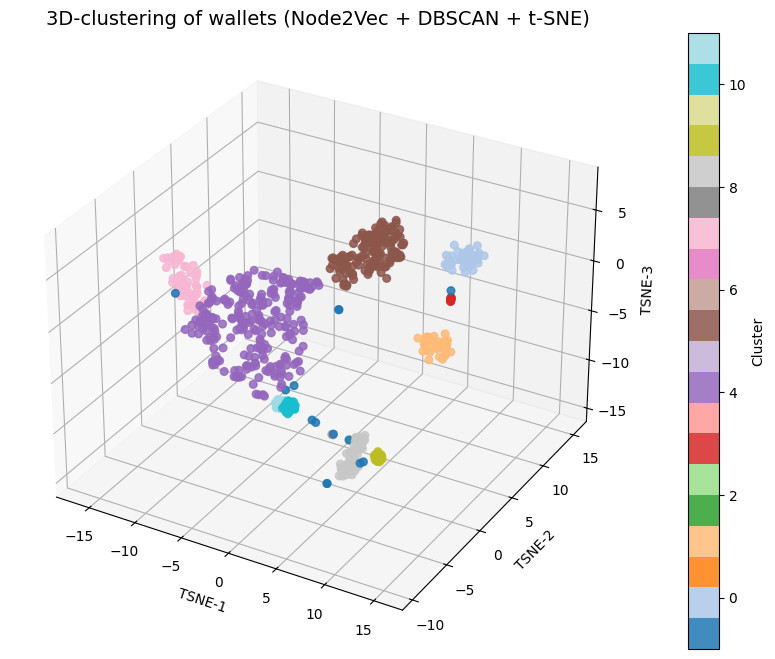

In [64]:
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # для 3D-графика

# Кластеризация DBSCAN
db = DBSCAN(eps=0.3, min_samples=3)
labels = db.fit_predict(X)

# t-SNE в 3D
tsne = TSNE(n_components=3, random_state=42, perplexity=30)
X_3d = tsne.fit_transform(X)

# Визуализация
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_3d[:, 0], X_3d[:, 1], X_3d[:, 2],
    c=labels, cmap='tab20', s=30, alpha=0.85
)

ax.set_title("3D-clustering of wallets (Node2Vec + DBSCAN + t-SNE)", fontsize=14)
ax.set_xlabel("TSNE-1")
ax.set_ylabel("TSNE-2")
ax.set_zlabel("TSNE-3")

fig.colorbar(scatter, label='Cluster')
plt.show()


### Intra-Cluster Analysis of Wallet Groups

Interestingly, the number of clusters identified via **DBSCAN** on the Node2Vec embeddings was significantly higher than the number of communities originally discovered using **modularity-based Louvain clustering**. This suggests that node embeddings captured **finer-grained structural and behavioral distinctions** between wallets that were previously grouped into broader communities.

To further investigate this, I performed an **intra-cluster analysis** within each DBSCAN-detected group. For every cluster, I reconstructed the **subgraph** induced by its wallet nodes


In [21]:
cluster_df = pd.DataFrame({
    'wallet': wallet_ids,
    'cluster': labels
})

tx_data = UID_total[['From', 'To', 'UID', 'Token Symbol', 'Amount/TokenID', 'Time(UTC)']].copy()
tx_data['Time(UTC)'] = pd.to_datetime(tx_data['Time(UTC)'])
tx_info = tx_data.merge(cluster_df, left_on='From', right_on='wallet', how='inner')

In [22]:
def avg_time_diff(times):
    times_sorted = times.sort_values()
    diffs = times_sorted.diff().dropna().dt.total_seconds()
    return diffs.mean() if not diffs.empty else np.nan

agg = tx_info.groupby('cluster').agg(
    count_wallets=('wallet', 'nunique'),
    count_tx=('From', 'count'),
    avg_amount=('Amount/TokenID', 'mean'),
    total_amount=('Amount/TokenID', 'sum'),
    unique_tokens=('Token Symbol', 'nunique'),
    uid_count=('UID', 'nunique'),
    avg_time_between_tx=('Time(UTC)', avg_time_diff)
).reset_index()


In [36]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math

def plot_all_clusters_grid(internal=True, max_clusters=None):
    unique_clusters = sorted(set(labels) - {-1})
    plotted_graphs = []

    for cluster_id in unique_clusters:
        cluster_wallets = [wallet_ids[j] for j, lbl in enumerate(labels) if lbl == cluster_id]

        
        if internal:
            tx = UID_total[
                UID_total['From'].isin(cluster_wallets) &
                UID_total['To'].isin(cluster_wallets)
            ].copy()
        else:
            tx = UID_total[UID_total['From'].isin(cluster_wallets)].copy()

        if tx.empty:
            continue  

        tx['Time(UTC)'] = pd.to_datetime(tx['Time(UTC)'])
        node_sums = tx.groupby('From')['Amount/TokenID'].sum().to_dict()

        
        G = nx.DiGraph()
        for _, row in tx.iterrows():
            G.add_edge(row['From'], row['To'], time=row['Time(UTC)'], amount=row['Amount/TokenID'])

       
        min_sum = min(node_sums.values()) if node_sums else 0
        max_sum = max(node_sums.values()) if node_sums else 1
        node_sizes = [
            100 + 900 * (node_sums.get(node, 0) - min_sum) / (max_sum - min_sum)
            if max_sum != min_sum else 300
            for node in G.nodes()
        ]

        
        times = [attr['time'] for _, _, attr in G.edges(data=True)]
        t_min, t_max = min(times), max(times)
        alphas = [
            (t - t_min).total_seconds() / (t_max - t_min).total_seconds() if t_max != t_min else 1.0
            for t in times
        ]

        plotted_graphs.append((G, node_sizes, alphas, cluster_id))

        if max_clusters and len(plotted_graphs) >= max_clusters:
            break

  
    n = len(plotted_graphs)
    if n == 0:
        print("❌ No cluster available with inner transactions")
        return

    n_cols = 3
    n_rows = math.ceil(n / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = axes.flatten()

    for i, (G, node_sizes, alphas, cluster_id) in enumerate(plotted_graphs):
        ax = axes[i]
        pos = nx.spring_layout(G, seed=42)

        for (u, v, attr), alpha in zip(G.edges(data=True), alphas):
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], alpha=alpha, edge_color='gray', ax=ax)

        nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='dodgerblue', alpha=0.8, edgecolors='black', ax=ax)

        ax.set_title(f"Кластер {cluster_id} ({'внутри' if internal else 'исходящие'})", fontsize=11)
        ax.axis('off')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


❌ Нет кластеров с транзакциями для отображения.


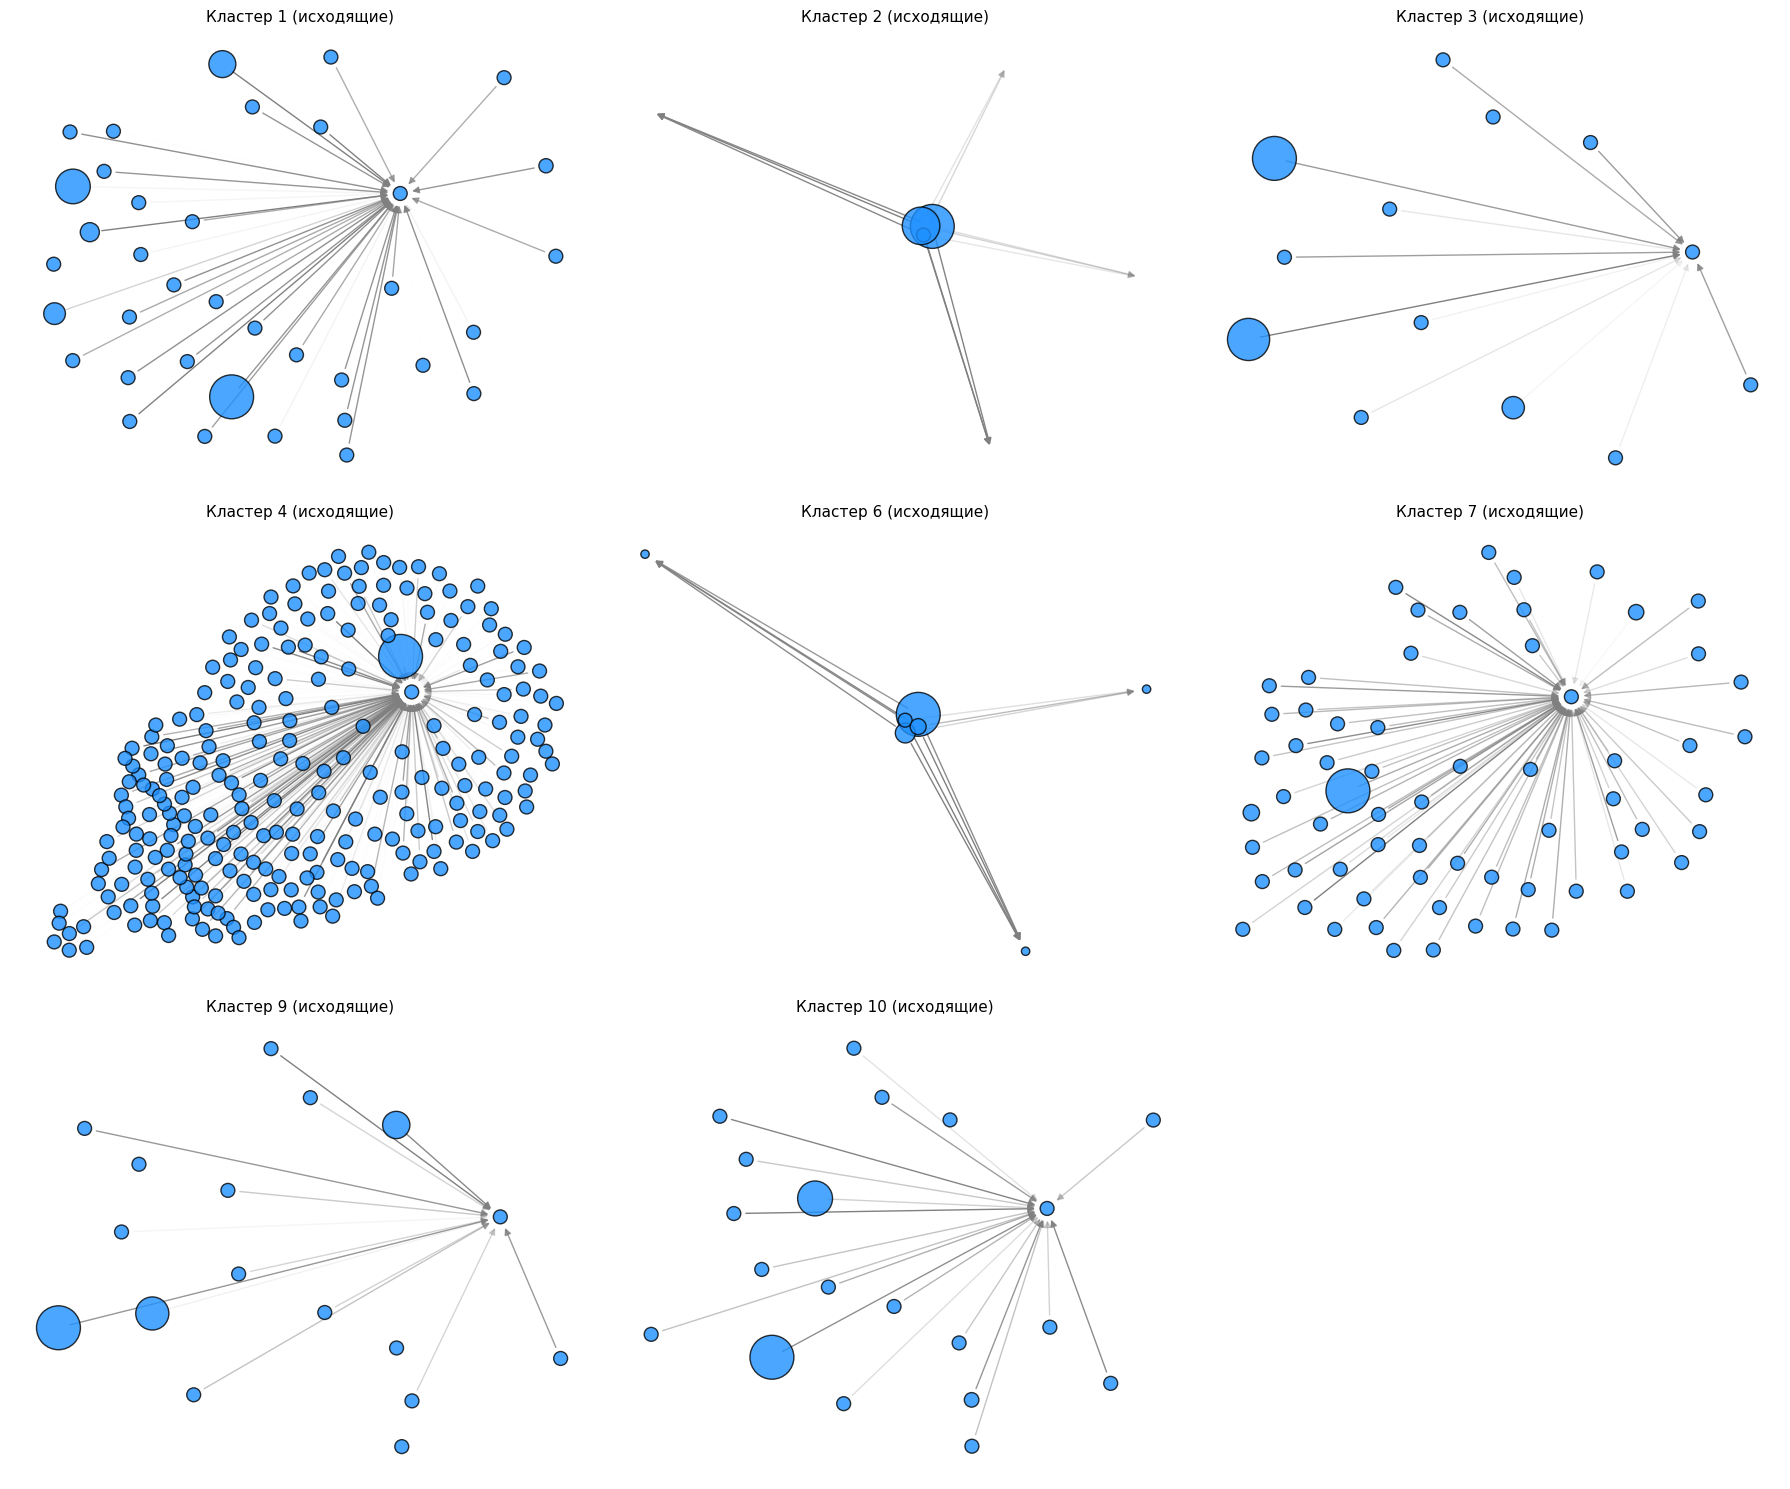

In [37]:
plot_all_clusters_grid(internal=True)     
plot_all_clusters_grid(internal=False)    


### Structured Fund Routing: Distributed Clusters Feeding External Sinks

A deeper examination of the transaction graphs reveals that multiple wallet clusters — though internally distinct — are funneling their funds toward **individual external sink wallets** located *outside* their own cluster boundaries. In several cases, we also observe **intermediary wallets** connecting these cluster outputs to final sinks, forming multi-stage transfer chains.

---

#### 🔍 Why Use Multiple Clusters?

From an attacker’s perspective, the use of **multiple separate clusters** (instead of one large group) provides key operational advantages:

- **Avoiding detection via decentralization**: smaller clusters with limited internal transactions and outward-facing structure appear less suspicious in isolation;
- **Bypassing volume thresholds**: distributing incoming funds across wallets prevents triggering alerts tied to transfer limits, volume anomalies, or frequency-based heuristics;
- **Evading graph-based clustering**: keeping source wallets loosely connected or isolated makes it harder for traditional community detection algorithms to group them together.

---

#### 🧠 Role of Intermediary Wallets

The presence of **middle-layer wallets** that aggregate funds from clusters and pass them to ultimate sinks suggests a deliberate attempt at:

- **Obfuscation of fund origin** — breaking direct links between bonus/farming wallets and collector wallets;
- **Delay-based laundering** — introducing time gaps between transactions to further hinder temporal correlation;
- **Simulating normal flow** — by interspersing "normal-looking" transactions (e.g., different sizes, timings) at intermediary stages.

---

#### 🛠️ Use Cases in Fraudulent Behavior

This type of structure is highly characteristic of:

1. **Bonus hunting with staged drainage**: each wallet claims a bonus, sends it to a cluster-level collector, which then funnels funds to a central wallet via a clean intermediary.

2. **Affiliate/self-referral layering**: creating multiple user accounts tied together by referral links, each generating reward payouts, which are then collected and passed along to a payout wallet.

3. **Synthetic client networks**: for manipulation of trading volumes, engagement metrics, or payout triggers — all while keeping the architecture modular to reduce exposure.

---

#### ⚠️ Risk Implications for the Broker

- **Unprofitable flows**: all observed activity is extractive, with no actual trading or meaningful engagement;
- **KYC abuse and identity fragmentation**: likely use of synthetic or low-quality identity data;
- **Loss exposure**: broker pays out promotional funds, spreads, or affiliate commissions with no actual economic return.

---

#### 🧭 Analytical Actions

To further profile these structures, I suggest:
- **Mapping intermediary wallets** and calculating their betweenness centrality;
- Using **path-based heuristics** to trace flow chains across clusters;
- Applying **label propagation or graph neural networks** to reveal hidden affiliations;
- Cross-referencing **device/IP/KYC metadata** across wallets to detect ownership overlap.

---

### ✅ Practical Outcome: Proof of Client Affiliation

This structured graph analysis was not just theoretical — it directly supported a real-world case involving suspected abuse of promotional programs. By tracing the fund flows from distributed wallet clusters through intermediary nodes to common external sinks, I was able to **demonstrate with high confidence the operational affiliation of these wallets**, even in the **absence of direct technical evidence** such as shared device fingerprints (CID), IP addresses, or KYC overlap.

Despite no overlap in traditional metadata, the combination of:

- **transactional convergence** (many wallets funding the same endpoint),
- **repetitive structural motifs** (fan-out to intermediary → sink),
- and **temporal coordination**

clearly pointed to **a single controlling entity or coordinated group**.

This insight played a key role in supporting **risk management decisions**, including:

- Blocking of further promotional payouts,
- Flagging of associated accounts for enhanced due diligence,
- Updating internal fraud detection rules to account for similar patterns.

The ability to transition from community-level modularity analysis to detailed **structural tracing with Node2Vec embeddings and cluster-specific subgraph exploration** proved instrumental in unmasking **coordinated client behavior** that would otherwise remain hidden in raw data — especially when traditional identifiers offer no overlap.
